In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Import Data

Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read File

In [ ]:
# Specify the file path within your Google Drive
file_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/hmnist_28_28_RGB.csv'  # Replace with your actual file path

# Read the file using Pandas (assuming it's a CSV file)
df = pd.read_csv(file_path)

# Data Preprocessing

Take out the label

In [ ]:
y = df['label']
x = df.drop(columns = ['label'])

In [ ]:
print(x.shape)

(10015, 2352)


Oversample to handle class imbalance

In [ ]:
#from imblearn.over_sampling import RandomOverSampler
#oversample = RandomOverSampler()
#x,y  = oversample.fit_resample(x,y)

Specify Labels

In [ ]:
print(y.nunique())

7


In [ ]:
print(y.value_counts())
#nv       6705 benign
#mel      1113 malignant
#bkl      1099 benign
#bcc       514 malignant
#akiec     327 malignant
#vasc      142 benign
#df        115 benign

4    6705
6    1113
2    1099
1     514
0     327
5     142
3     115
Name: label, dtype: int64


Replace 4, 2, 5, 3 with benign (0), and rest with malignant (1)

In [ ]:
# Replace values 1, 6, 0 with 1
y.replace({1: 1, 6: 1, 0: 1}, inplace=True)

# Replace values 4, 2, 5, and 3 with 0
y.replace({4: 0, 2: 0, 5: 0, 3: 0}, inplace=True)

In [ ]:
print(y.value_counts())
# benign 8061
# malignant 1954

0    8061
1    1954
Name: label, dtype: int64


Oversampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
oversample = RandomOverSampler()
x,y  = oversample.fit_resample(x,y)

In [ ]:
print(y.value_counts())

0    8061
1    8061
Name: label, dtype: int64


Reshape data

In [ ]:
x = np.array(x).reshape(-1,28,28,3)
print('Shape of X :',x.shape)

Shape of X : (16122, 28, 28, 3)


Convert Shape

In [ ]:
from scipy.ndimage import zoom

images = x

# Define the desired size (224x224)
desired_size = (72, 72)

# Upscale the images using interpolation
upscaled_images = np.zeros((images.shape[0],) + desired_size + (3,))
for i in range(images.shape[0]):
    for channel in range(3):
        upscaled_images[i, :, :, channel] = zoom(images[i, :, :, channel],
                                                 (desired_size[0] / images.shape[1], desired_size[1] / images.shape[2]))
print(upscaled_images.shape)

(16122, 72, 72, 3)


In [ ]:
x = upscaled_images
print(x.shape)

(16122, 72, 72, 3)


Standardization

In [ ]:
x = (x-np.mean(x))/np.std(x)

Train-Test Splitting

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.2, random_state=1)

In [ ]:
print(Y_train.value_counts())
print(Y_test.value_counts())

1    6451
0    6446
Name: label, dtype: int64
0    1615
1    1610
Name: label, dtype: int64


# Model Training

In [ ]:
from keras.applications.vgg16 import VGG16

In [ ]:
# Clear the TensorFlow session
tf.keras.backend.clear_session()

Pre-trained VGG16 Model

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(72, 72, 3)) # do not include fully connected layers
base_model.trainable = False # Freezing CNN layers

58889256/58889256 [==============================] - 3s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 72, 72, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 72, 72, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 36, 36, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 36, 36, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 18, 18, 128)       0     

In [ ]:
from keras import layers, models
from keras.layers import BatchNormalization

model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.BatchNormalization(),
    layers.Dense(64, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                        

In [ ]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.binary_crossentropy,
    metrics=['accuracy']
)

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

In [ ]:
history = model.fit(X_train,
                    Y_train,
                    validation_split=0.2,
                    batch_size = 128,
                    epochs = 30,
                    callbacks=[callback])

Epoch 1/30
81/81 [==============================] - ETA: 0s - loss: 0.4361 - accuracy: 0.7996
Epoch 1: saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 24s 128ms/step - loss: 0.4361 - accuracy: 0.7996 - val_loss: 0.4579 - val_accuracy: 0.7957
Epoch 2/30
80/81 [============================>.] - ETA: 0s - loss: 0.2836 - accuracy: 0.8844
Epoch 2: saving model to best_model.h5
81/81 [==============================] - 7s 82ms/step - loss: 0.2833 - accuracy: 0.8848 - val_loss: 0.3846 - val_accuracy: 0.8310
Epoch 3/30
80/81 [============================>.] - ETA: 0s - loss: 0.2018 - accuracy: 0.9241
Epoch 3: saving model to best_model.h5
81/81 [==============================] - 7s 81ms/step - loss: 0.2019 - accuracy: 0.9239 - val_loss: 0.3317 - val_accuracy: 0.8612
Epoch 4/30
80/81 [============================>.] - ETA: 0s - loss: 0.1381 - accuracy: 0.9558
Epoch 4: saving model to best_model.h5
81/81 [==============================] - 7s 84ms/step - loss: 0.1384 - accuracy: 0.9554 - val_loss: 0.2885 - val_accuracy: 0.8798
Epoch 5/30
80/81 [============================>.] - ETA: 0s - loss: 0.0946 - ac

# Plot Model Progression

Accuracy (training vs validation dataset)

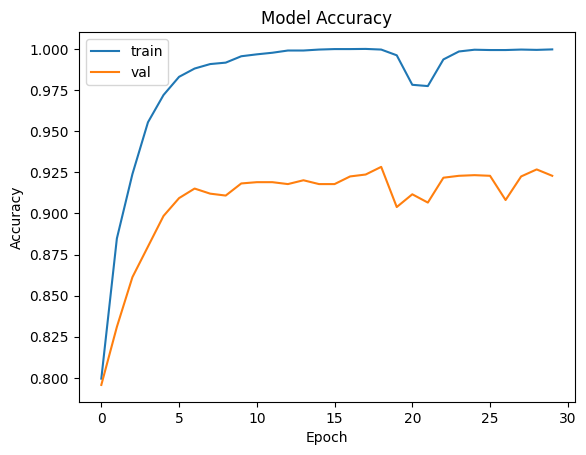

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Loss (training vs validation dataset)

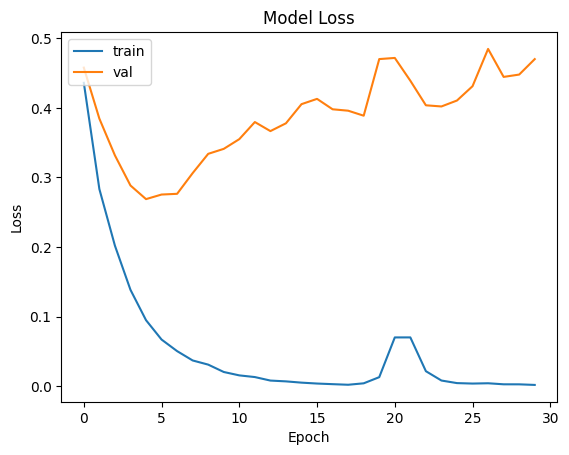

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load best model weights

In [ ]:
model.load_weights('best_model.h5')

Save Best Model

In [ ]:
# Load your pre-trained model (replace 'model.h5' with your model's filename)
best_model = tf.keras.models.load_model('best_model.h5')
# Define the path where you want to save the model
model_save_path = '/content/drive/My Drive/Colab Notebooks/Skin Cancer Classification/'

# Save the best model to Google Drive
best_model.save(model_save_path + 'best_model_vgg16.h5')
# Get the list of all layers in the model
all_layers = best_model.layers

# Loop through the layers and print their weights if they have any
for layer in all_layers:
    if layer.weights:
        print(f"Layer: {layer.name}")
        for weight in layer.weights:
            print(f"  {weight.name}:")
            print(weight.numpy())

Layer: vgg16
  block1_conv1/kernel:0:
[[[[ 4.29470569e-01  1.17273867e-01  3.40129584e-02 ... -1.32241577e-01
    -5.33475243e-02  7.57738389e-03]
   [ 5.50379455e-01  2.08774377e-02  9.88311544e-02 ... -8.48205537e-02
    -5.11389151e-02  3.74943428e-02]
   [ 4.80015397e-01 -1.72696680e-01  3.75577137e-02 ... -1.27135560e-01
    -5.02991639e-02  3.48965675e-02]]

  [[ 3.73466998e-01  1.62062630e-01  1.70863140e-03 ... -1.48207128e-01
    -2.35300660e-01 -6.30356818e-02]
   [ 4.40074533e-01  4.73412387e-02  5.13819456e-02 ... -9.88498852e-02
    -2.96195745e-01 -7.04357103e-02]
   [ 4.08547401e-01 -1.70375049e-01 -4.96297423e-03 ... -1.22360572e-01
    -2.76450396e-01 -3.90796512e-02]]

  [[-6.13601133e-02  1.35693997e-01 -1.15694344e-01 ... -1.40158370e-01
    -3.77666801e-01 -3.00509870e-01]
   [-8.13870355e-02  4.18543853e-02 -1.01763301e-01 ... -9.43124294e-02
    -5.05662560e-01 -3.83694321e-01]
   [-6.51455522e-02 -1.54351532e-01 -1.38038069e-01 ... -1.29404560e-01
    -4.6224379

# Model Testing

In [ ]:
#loss, acc = model.evaluate(X_test, Y_test, verbose=2)

In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(X_test)
#y_pred_labels = np.argmax(y_pred_ohe, axis=1)

101/101 [==============================] - 4s 26ms/step


In [ ]:
threshold = 0.9
y_pred_labels = (y_pred_ohe >= threshold).astype(int)

In [ ]:
# Save predictions as a NumPy array
np.save('test.npy', Y_test)
np.save('vgg16_predictions.npy', y_pred_labels)

In [ ]:
print(y_pred_labels)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]


In [ ]:
confusion_matrix = metrics.confusion_matrix(y_true=Y_test, y_pred=y_pred_labels)
print(confusion_matrix)

[[1487  128]
 [  65 1545]]


In [ ]:
from sklearn.metrics import classification_report
class_labels = ['benign', 'malignant']
report = classification_report(Y_test, y_pred_labels, target_names = class_labels)
print(report)

              precision    recall  f1-score   support

      benign       0.96      0.92      0.94      1615
   malignant       0.92      0.96      0.94      1610

    accuracy                           0.94      3225
   macro avg       0.94      0.94      0.94      3225
weighted avg       0.94      0.94      0.94      3225



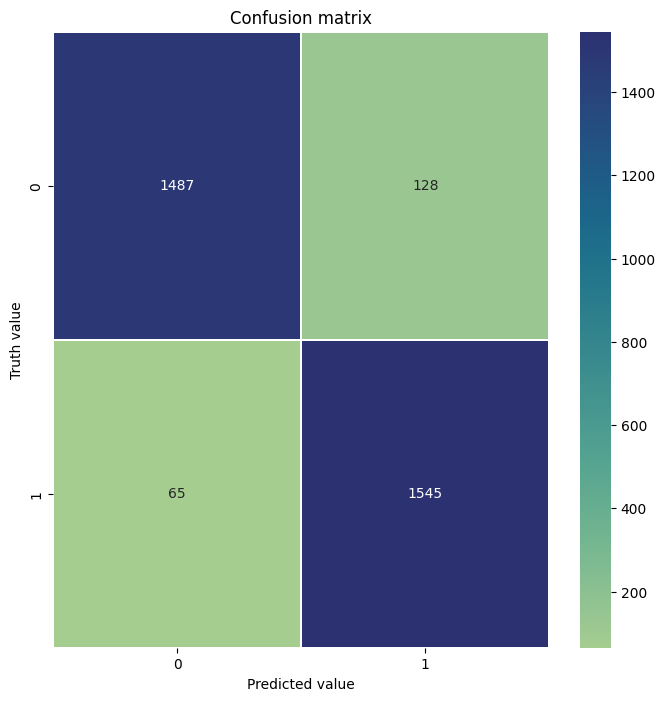

In [ ]:
import seaborn as sns

cm = confusion_matrix
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2)
plt.title('Confusion matrix')
plt.xlabel('Predicted value')
plt.ylabel('Truth value')
plt.show()
#print(confusion_matrix(Y_test, y_pred_labels))

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(Y_test, y_pred_labels)
precision = precision_score(Y_test, y_pred_labels)
recall = recall_score(Y_test, y_pred_labels)
f1 = f1_score(Y_test, y_pred_labels)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")

Accuracy: 0.94
Precision: 0.92
Recall: 0.96
F1-score: 0.94


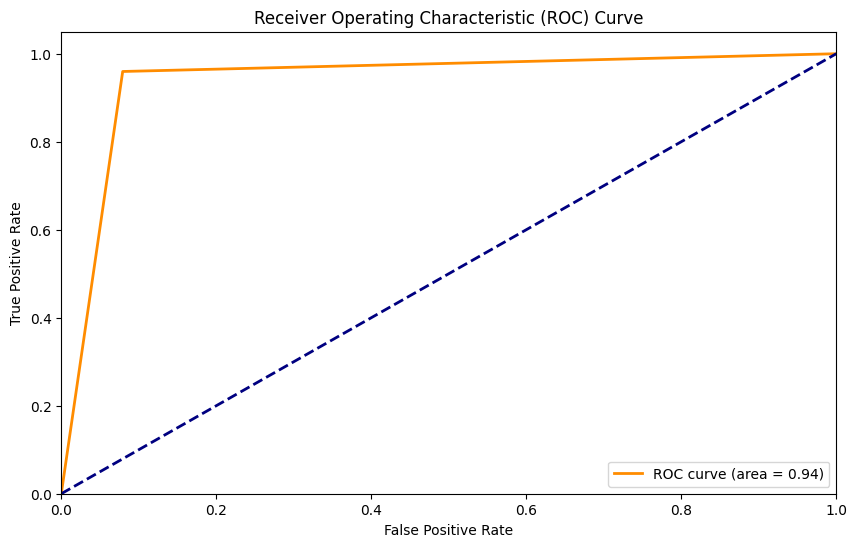

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(Y_test, y_pred_labels)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()